Author: Brian Erichsen Fagundes

Data Manipulation and NN architecture

In [13]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler


# fetches data from excel file
excel_data = pd.read_excel('historical_prices.xlsx', sheet_name=None)
combined_data = pd.DataFrame() # initiate empty data that will be combined

# per each sheet in excell file set stock to specific stock and concatenate data
for sheet_name, df in excel_data.items():
    df['Stock'] = sheet_name
    combined_data = pd.concat([combined_data, df], ignore_index=True)

#print(combined_data.info())
#print(combined_data.columns)
#print(combined_data.head())
#print(combined_data.tail())

# this step is crucial for NN LSTM training
scaler = MinMaxScaler(feature_range=(0, 1))

# 2D numpy array from scaling columns
scaled_data = scaler.fit_transform(combined_data[['Close', 'Volume']])
#scaled_data[:,0] - all rows from 1st column - Close
#scaled_data[:, 1] - Volume

sequence_length = 60
x_train, y_train = [],[]
# splits x_t and y_t
# Len of data number of training examples, sequence len is number of steps, 1 feature
# For y_train - 1D array; since we keeping only stock prices (1 feature)
for i in range(sequence_length, len(scaled_data)):
    #only keeping close price for now
    # for using volume as well --
    # x_train.append(scaled_data[i-sequence_length:i, :])
    x_train.append(scaled_data[i-sequence_length:i, 0])
    y_train.append(scaled_data[i, 0])# close for the target

# transforms data into numpy array for model
x_train, y_train = np.array(x_train), np.array(y_train)
# reshapes it to 3D (samples, time steps, features)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1)),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25),
    Dense(1)
])

# model.compile - learn process before training the model
# adam - adaptive learning - and MSE for regression
model.compile(optimizer='adam', loss='mean_squared_error')
# trains the model in provided data -- x input; y target (labels)
#model.fit(x_train, y_train, batch_size=32, epochs=10, validation_split=0.2, shuffle=True)
model.fit(x_train, y_train, batch_size=1, epochs=1)

model.save('stock_prediction_model.h5')




/Users/brianerichsenfagundes/Desktop/6017/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5830/5830 ━━━━━━━━━━━━━━━━━━━━ 36s 6ms/step - loss: 0.0041


In [14]:
from sklearn.model_selection import train_test_split

#splitting the data into train and test sets
sequence_length = 60
x_data, y_data = [], []

for i in range(sequence_length, len(scaled_data)):
    x_data.append(scaled_data[i-sequence_length:i, 0])
    y_data.append(scaled_data[i, 0])

x_data, y_data = np.array(x_data), np.array(y_data)
train_size = int(len(x_data) * 0.8)
#[x:y] -- from 0 to train size and from train size to the end
x_train, x_test = x_data[:train_size], x_data[train_size:]
y_train, y_test = y_data[:train_size], y_data[train_size:]

#reshape data for LSTM model which expects a 3D
# input - samples, time steps and number of features
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [15]:
# adam - adaptive learning - and MSE for regression
model.compile(optimizer='adam', loss='mean_squared_error')
# trains the model in provided data -- x input; y target (labels)
model.fit(x_train, y_train, batch_size=1, epochs=1)

4664/4664 ━━━━━━━━━━━━━━━━━━━━ 30s 6ms/step - loss: 2.6547e-04


In [16]:
from sklearn.metrics import mean_squared_error
# Model Evaluation
predicted_stock_price = model.predict(x_test)
# Mean squared error calculation
mse = mean_squared_error(y_test, predicted_stock_price)
sqmse = np.sqrt(mse)
print(f'Test MSE: {mse:.4f}')
print(f'Test SQMSE: {sqmse:.4f}')

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Test MSE: 0.2867
Test SQMSE: 0.5354


So far it seems that model can predictict well the prices of stocks.


Using only Close price -- MSE: 0.0017 and SQMSE: 0.0414

In [17]:
# Adding Cross Validation for further testing accuracy
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=5)

for train_index, test_index in tscv.split(x_data):
    x_train_cv, x_test_cv = x_data[train_index], x_data[test_index]
    y_train_cv, y_test_cv = y_data[train_index], y_data[test_index]
    
    x_train_cv = np.reshape(x_train_cv, (x_train_cv.shape[0], x_train_cv.shape[1], 1))
    x_test_cv = np.reshape(x_test_cv, (x_test_cv.shape[0], x_test_cv.shape[1], 1))

    model.fit(x_train_cv, y_train_cv, batch_size=1, epochs=1)
    
    predictions = model.predict(x_test_cv)
    mse_cv = mean_squared_error(y_test_cv, predictions)
    print(f'MSE for fold: {mse_cv:.4f}')


975/975 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 1.0618e-04
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
MSE for fold: 0.0000
1946/1946 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - loss: 2.1378e-05
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
MSE for fold: 0.0000
2917/2917 ━━━━━━━━━━━━━━━━━━━━ 18s 6ms/step - loss: 2.6408e-05
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
MSE for fold: 0.0000
3888/3888 ━━━━━━━━━━━━━━━━━━━━ 24s 6ms/step - loss: 2.2634e-05
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
MSE for fold: 0.0012
4859/4859 ━━━━━━━━━━━━━━━━━━━━ 47s 10ms/step - loss: 0.0019
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
MSE for fold: 0.0161


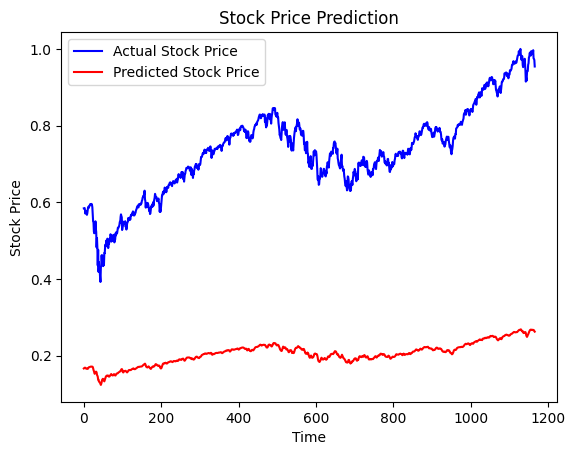

In [18]:
import matplotlib.pyplot as plt

plt.plot(y_test, color='blue', label='Actual Stock Price')
plt.plot(predicted_stock_price, color='red', label='Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

Notes: Test it with Close and Volume feature and compare accuracy of both & adding the S&P 500 data as well and test its accuracy and how well it impacts overall predictions. Currently the prediction is the next day -- we could also dynamically do a x variable number of days ahead to test its prediction.

In [19]:
from tensorflow.keras.models import load_model

ticker = 'TSLA'

new_data = scaler.fit_transform(combined_data[['Close']])
x_input = np.array([scaled_data[:, 0]])
x_input = np.reshape(x_input, (x_input.shape[0], x_input.shape[1], 1))

model = load_model('stock_prediction_model.h5')
predicted_stock_price = model.predict(x_input)

predicted_price = scaler.inverse_transform(
    np.array([predicted_stock_price[0], [0]])
)[0][0]

print(f'Predicted Closing Price for {ticker} for 08-19-2024: {predicted_price:.2f}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step
Predicted Closing Price for TSLA for 08-19-2024: 5514.63


Testing for the next day seems to be going ok and logic has been tested as well on app.py for frontend. Let's give a try by only using the 60 last days of data to check for accuracy instead of using the whole data.

In [20]:
# Load model
model = load_model('stock_prediction_model.h5')

# Load and scale data
excel_data = pd.read_excel('historical_prices.xlsx', sheet_name=None)
combined_data = pd.DataFrame()

for sheet_name, df in excel_data.items():
    df['Stock'] = sheet_name
    combined_data = pd.concat([combined_data, df], ignore_index=True)

#normalizes values from 0 to 1 - really import for recurrent NN
scaler = MinMaxScaler(feature_range=(0, 1))
# transforms data into 2D numpy array
scaled_data = scaler.fit_transform(combined_data[['Close']])

# Prepare input for prediction
ticker = 'TSLA'

#transforms the scaled data - 2D numpy array of scaled Close prices
last_60_days = combined_data[combined_data['Stock'] == ticker].tail(60)
last_60_days_scaled = scaler.transform(last_60_days[['Close']])

#converts 1D to 2D
# x chooses 1st column (the one has closing prices) : all rows; 0 for 1st column (60, 1)
x_input = np.array([last_60_days_scaled])

# batch size, time_steps, features
# reshapes x input into 3D --> since model expects 3D input -- 1, 60, 1
x_input = np.reshape(x_input, (x_input.shape[0], x_input.shape[1], 1))

# Predict future prices
# the predicted price is a 2D array
predicted_stock_price = model.predict(x_input)
#access the 1st element of prediction - transform it to 2D - inverse transform changes from
# scaled 0 - 1 back to normal value
predicted_price = scaler.inverse_transform(
    np.array([predicted_stock_price[0], [0]])
)[0][0]

# Print predictions
print(f'Predicted Prices for {ticker} is: {predicted_price:.2f}.')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
Predicted Prices for TSLA is: 212.33.


This is actually really impressive; because our file currently - historical prices
its data finish on 08-16 with TSLA closing price for 216.12 and it predicts for the 08-19 for 222.33 where on Yahoo Finance states that TSLA price for 09-19 is 222.72.

So far NN predictis one day ahead closing price of a given stock. Let's change the model so that the output is 2D instead 1D so we can predicti n days in the future from today.

In [21]:
# this new model will have 2 Y output so that we can predict n days in the future the close
# price of a given stock

sequence_length = 60
n_future = 5 #number of days ahead we want to predict
x_train, y_train = [],[]
# splits x_t and y_t
# Len of data number of training examples, sequence len is number of steps, 1 feature
# For y_train - 1D array; since we keeping only stock prices (1 feature)
for i in range(sequence_length, len(scaled_data) - n_future + 1):
    #only keeping close price for now
    # for using volume as well --
    # x_train.append(scaled_data[i-sequence_length:i, :])
    x_train.append(scaled_data[i-sequence_length:i])
    y_train.append(scaled_data[i:i+n_future, 0])# close for the target

# transforms data into numpy array for model
x_train, y_train = np.array(x_train), np.array(y_train)
# reshapes it to 3D (samples, time steps, features)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], x_train.shape[2]))

model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25),
    Dense(n_future)
])

# model.compile - learn process before training the model
# adam - adaptive learning - and MSE for regression
model.compile(optimizer='adam', loss='mean_squared_error')
# trains the model in provided data -- x input; y target (labels)
#model.fit(x_train, y_train, batch_size=32, epochs=10, validation_split=0.2, shuffle=True)
model.fit(x_train, y_train, batch_size=1, epochs=1)

model.save('stock_prediction_model2.h5')

/Users/brianerichsenfagundes/Desktop/6017/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5826/5826 ━━━━━━━━━━━━━━━━━━━━ 38s 6ms/step - loss: 0.0047


In [22]:
# will try to resolve predicting n-days in the future a stock prediction to be returned
# Load model
model = load_model('stock_prediction_model2.h5')

# Load and scale data
excel_data = pd.read_excel('historical_prices.xlsx', sheet_name=None)
combined_data = pd.DataFrame()

for sheet_name, df in excel_data.items():
    df['Stock'] = sheet_name
    combined_data = pd.concat([combined_data, df], ignore_index=True)

#normalizes values from 0 to 1 - really import for recurrent NN
scaler = MinMaxScaler(feature_range=(0, 1))
# transforms data into 2D numpy array
scaled_data = scaler.fit_transform(combined_data[['Close']])

# Prepare input for prediction
ticker = 'TSLA'

#transforms the scaled data - 2D numpy array of scaled Close prices
last_60_days = combined_data[combined_data['Stock'] == ticker].tail(60)
last_60_days_scaled = scaler.transform(last_60_days[['Close']])

#converts 1D to 2D
# x chooses 1st column (the one has closing prices) : all rows; 0 for 1st column (60, 1)
x_input = np.array([last_60_days_scaled])

# batch size, time_steps, features
# reshapes x input into 3D --> since model expects 3D input -- 1, 60, 1
x_input = np.reshape(x_input, (x_input.shape[0], x_input.shape[1], 1))

predicted_stock_price = model.predict(x_input)
#reshapes prediction back to 2D
predicted_stock_price = np.array(predicted_stock_price).reshape(-1, 1)

# dummy array to match original number of features in the scaled data - 1 since
# original scaling was based on only Close
dummy_array = np.zeros((predicted_stock_price.shape[0], scaled_data.shape[1] - 1))
# concatenate both so we have proper shape for inverse scaling process
# axis 1 makes sure we append columns side by side
predicted_stock_price_full = np.concatenate((predicted_stock_price, dummy_array), axis=1)
#reverts back scaled to normal data we only extract :, 0 - only close columns and take out the
# dummy values
predicted_price = scaler.inverse_transform(predicted_stock_price_full)[:, 0]

for i, price in enumerate(predicted_price, 1):
    print(f'Predicted Price for day {i}: {price:.2f}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
Predicted Price for day 1: 278.13
Predicted Price for day 2: 295.00
Predicted Price for day 3: 305.72
Predicted Price for day 4: 286.12
Predicted Price for day 5: 302.95
